# Integrating with the Minhashing Library

In [1]:
"""
The traditional LSH appraoch to a hypothetical many-to-many document similarity task. 
The objective is to bucket similar documents together. The implementation is done through 
the `LSH` class which leverages on `dask.bag` functionality and methods to 
parallelize the banding technique. Specifically, the map (hash function) and reduce 
(bucketing) tasks.

Note: importing the model automatically initializes a dask client.

BY: Mike Dorosan, 2022
"""

import dask.bag as db

import numpy as np
import matplotlib.pyplot as plt


class LSH():
    """The LSH class for a many-to-many document similarity task.

    Attributes
    ----------
    signature : 2-D np.array
        document minhash signatures with dimension n (samples) by m (signature size)
    bands : int
        number of bands
    r : int
        number of rows per band derived from bands
    hash_functions : list, default=None
        a list of hash functions with size equivalent to the number of 
        bands. If None, the native python hash function is applied.
    band_dict : dict
        dictionary with band labels as keys and 
        (set/doc index, signature band) tuples as values  
    band_buckets : dict
        a dictionary with hash bucket as keys and a list of similar 
        document indices as values
    Methods
    -------

    """

    def __init__(self, signature):
        """Initialize class

        Parameters
        ----------
        signature : 2-D np.array, or dask.bag 
            document minhash signatures with dimension n (samples) by m (signature size)
            dask.bag of tuples (set/doc index, )
        """
        self.signature = signature
        self.bands = None  # number of bands
        self.r = None  # rows per band, band size
        self.hash_functions = None
        self.band_dict = {}
        self.band_buckets = {}

    def make_bands(self, bands):
        """Takes in the desired number of `bands` as a parameter and returns 
        a dictionary with band labels as keys and `dask.bag` of (set/document 
        index, signature band) tuples

        Parameters
        ----------
        bands : int 
            desired number of bands

        Returns
        -------
        band_dict : dict 
            dictionary with band labels as keys and 
            (set/doc index, signature band) tuples as values    
        """

        self.bands = bands
        
        if type(self.signature) == db.core.Bag:
            print("Input signature a dask bag.")
            signature_size = len(self.signature.take(1)[0][1]) # get size of signature
            assert signature_size % self.bands == 0, "Number of bands not a factor of signature size."
            self.r = int(signature_size / self.bands)
            
            for band_label, i in enumerate(range(0, signature_size, self.r)):
                band_bag = self.signature.map(lambda x: (x[0], np.array(x[1][i:i+self.r]))).repartition(1)
                self.band_dict[band_label] = band_bag
            
        elif type(self.signature) == np.ndarray:
            # check if number of bands divide columns equally
            print("Input signature a numpy array.")
            signature_size = self.signature.shape[1]
            assert signature_size % self.bands == 0, "Number of bands not a factor of signature size."

            self.r = int(signature_size / self.bands)

            for band_label, i in enumerate(range(0, signature_size, self.r)):
                band_bag = db.from_sequence(
                    zip(range(signature_size),
                        self.signature[:, i:i+self.r]), npartitions=1)
                self.band_dict[band_label] = band_bag
                
        else:
            raise "Input signature not a dask.bag.core.Bag or a numpy.ndarry"


        return self.band_dict

    def get_buckets(self, hash_functions=None, compute=False):
        """This method implementes the map-reduce step of the traditional 
        banding technique. Specifically, signature slices of each band are 
        hashed using `hash_functions` (map). The document indices are then 
        grouped according to their hash values.

        Parameters
        ----------
        hash_functions : list, default=None
            a list of hash functions with size equivalent to the number of 
            bands. If None, the native python hash function is applied.

        Returns
        -------
        band_buckets - dict 
            a dictionary with hash bucket as keys and a list of similar 
            document indices as values    
        """

        self.hash_functions = hash_functions
        if not hash_functions:
            # use python's built-in hasher
            self.hash_functions = [hash]

        for index, (key, value) in enumerate(self.band_dict.items()):
            # add checks here for hash_functions type
            if len(self.hash_functions) > 1:
                idx = index
            else:
                idx = 0
            self.band_buckets[key] = (
                value.map(
                    lambda x: (
                        x[0],
                        self.hash_functions[idx](x[1].tobytes())
                    )
                )
                .groupby(lambda x: x[1])  # groupby hash value
                # get only document index
                .map(lambda x: (x[0], list(list(zip(*x[1]))[0])))
            )
            if compute:
                self.band_buckets[key] = self.band_buckets[key].compute()

        return self.band_buckets

    def _prob_of_s(self, s):
        """Return the probability of similarity s given b and r"""
        return 1 - (1 - s**self.r)**self.bands

    def _get_approx_thresh(self):
        """Return approximate similarity threshold for chosen b and r"""
        thresh = (1/self.bands) ** (1/self.r)

        return thresh

    def plot_thresh(self, display_thresh=True, ax=None, **kwargs):
        """Plots the threshold plot according to number of bands.

        Parameters
        ----------
        display_thresh : bool, default=True 
            whether to display emphasis on the similarity threshold or not.

        ax : matplotlib.pyplot Axis, default=None 
            Axis for plotting. If None, use internally generated Axis object.

        **kwargs : keyword arguments for the matplotlib.pyplot.plot() function.

        Returns
        -------
        ax : matplotlib.pyplot Axis object
        """
        s_list = np.linspace(0, 1, num=50)
        p_list = np.array([self._prob_of_s(s) for s in s_list])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(s_list, p_list, **kwargs)

        if display_thresh:
            thresh = self._get_approx_thresh()
            ax.axvline(thresh, color='black', linestyle='--',
                       label=f'Similarity Threshold: {thresh:.2f}')

        ax.set_title('Probability of becoming a candidate given a similarity\nThe S-curve',
                     fontsize=15)
        ax.set_ylabel('Probability', fontsize=13)
        ax.set_xlabel('Jaccard Similarity of Documents', fontsize=13)
        ax.legend()
        self.ax_ = ax
        return self.ax_


In [19]:
from sklearn.datasets import fetch_20newsgroups

# Load the news group dataset without the headers, footers and quotes
newsgroup = fetch_20newsgroups(
    subset='train', remove=('headers', 'footers', 'quotes'))
newsgroup_data = newsgroup['data'][0:1000] # reduce size

In [3]:
from dask.distributed import Client
import dask.bag as db

client = Client()

In [20]:
newsgroup_bag = db.from_sequence(
    zip(range(len(newsgroup_data)), newsgroup_data))

In [21]:
import re


def clean_text(text):
    """Clean text by removing non-alphanumeric characters and replacing
    all blank space characters into a single space
    """
    return (re.sub(r'\s', r' ', re.sub(r'[^\w\s]', r'', text)).lower())

In [22]:
newsgroup_bag_cleaned = newsgroup_bag.map(lambda x: (x[0], clean_text(x[1])))

In [23]:
import sys
# sys.path.append('/home/mdorosan/2022/alis')

from alis.feature_extraction import MinhashLSH

In [24]:
# note our m here is the num_hash=10
# hence, we obtain signatures of size num_hash
minhasher = MinhashLSH(shingle_size=3, num_shingle_bucket=12, num_hash=10,
                       hash_size=2**12)

In [25]:
newsgroup_signatures = minhasher.transform(newsgroup_bag_cleaned)

In [26]:
newsgroup_signatures.take(10)

((0, [164, 41, 5, 141, 19, 109, 71, 3, 82, 11]),
 (1, [285, 41, 15, 141, 230, 16, 8, 3, 89, 35]),
 (2, [31, 41, 0, 26, 24, 52, 8, 3, 63, 5]),
 (3, [95, 1238, 1095, 487, 858, 700, 737, 129, 214, 1402]),
 (4, [94, 293, 145, 266, 484, 208, 134, 66, 136, 10]),
 (5, [45, 104, 300, 119, 85, 25, 71, 3, 59, 25]),
 (6, [131, 293, 25, 9, 6, 88, 98, 570, 202, 61]),
 (7, [128, 41, 0, 31, 6, 40, 17, 3, 42, 3]),
 (8, [530, 104, 110, 380, 124, 172, 521, 192, 89, 171]),
 (9, [90, 41, 30, 3, 42, 151, 17, 3, 7, 28]))

In [27]:
signatures_list = newsgroup_signatures.compute()
print("Corpus Length: ", len(signatures_list))

Corpus Length:  960


In [28]:
lsh = LSH(newsgroup_signatures)
lsh.make_bands(bands=2)
print("Rows per band: ", lsh.r)
print("Number of bands: ", lsh.bands)
buckets = lsh.get_buckets()
print("Group of buckets: ", len(buckets.keys()))

display(buckets)

Input signature a dask bag.
Rows per band:  5
Number of bands:  2
Group of buckets:  2


{0: dask.bag<lambda, npartitions=1>, 1: dask.bag<lambda, npartitions=1>}

In [29]:
buckets[0].repartition(10).compute()

[(-1716454029869641673, [0]),
 (-179318606695944902, [1]),
 (5648160113412653529, [2]),
 (853785114493865168, [3]),
 (-5993753671488363360, [4]),
 (-5431566772304493731, [5]),
 (-7626803925249234329, [6]),
 (-5109801883415055952, [7]),
 (2778392224031929693, [8]),
 (-8694804133197050926, [9]),
 (4594995475003161549, [10]),
 (-6504792793705016089, [11]),
 (3328822421320697126, [13]),
 (1858058013962220690, [14]),
 (-1520446328491657851, [15]),
 (-8265207054304488023, [16]),
 (-1436130737227402794, [17]),
 (7623737550075592085, [18]),
 (7349304399337303277, [19]),
 (-1405710614771148224, [20]),
 (2566661171384580581, [21]),
 (-2867106918154443864, [22]),
 (7980488407779965640, [23]),
 (4942437542763549662, [24]),
 (4583928878524618117, [25]),
 (5455517177727297968, [26]),
 (7458264023113392021, [27]),
 (1420441563300767891, [28]),
 (-4712928336590892429, [29]),
 (3103170889885538221, [30]),
 (-5032869465551542682, [31]),
 (1507476209662438897, [32]),
 (3461875031936745004, [33]),
 (-8815

In [30]:
# candidate pair for band zero
buckets[0].filter(lambda x: len(x[1]) > 1).compute()

[(-9017053666610740164, [302, 337])]

In [31]:
# candidate pair for band 1
buckets[1].filter(lambda x: len(x[1]) > 1).compute()

[(-9017053666610740164, [302, 337])]

In [35]:
newsgroup_data[302]

'Is it possible to do a "wheelie" on a motorcycle with shaft-drive?'

In [34]:
newsgroup_data[337]

']Is it possible to do a "wheelie" on a motorcycle with shaft-drive?\n\nyes.\n'

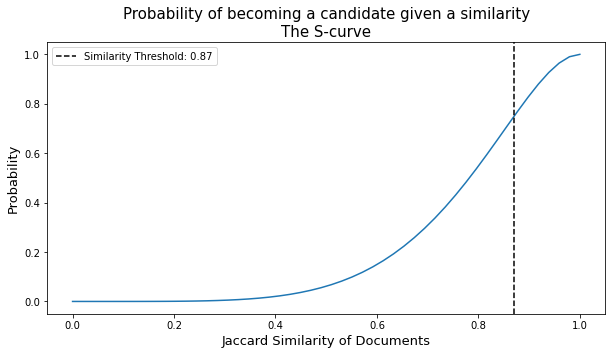

In [45]:
# plotting the s-curve
ax = lsh.plot_thresh()
plt.show()

In [48]:
signatures_dict = {k:v for k, v in signatures_list}

In [62]:
from itertools import combinations
from scipy.spatial.distance import jaccard

def jaccard_sim(u, v):
    return 1 - jaccard(u, v)

similarities = [jaccard_sim(signatures_dict[u_idx], signatures_dict[v_idx]) \
                for u_idx, v_idx in combinations(list(signatures_dict.keys()), 2)]


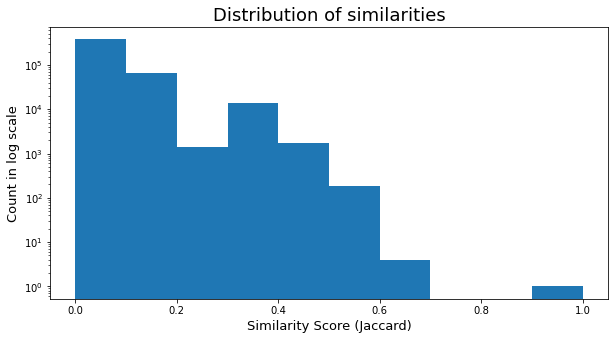

In [60]:
# jaccard similarity distribution
_, ax = plt.subplots(figsize=(10, 5))
ax.hist(similarities, bins=10, log=True)
ax.set_title('Distribution of similarities', fontsize=18)
ax.set_xlabel('Similarity Score (Jaccard)', fontsize=13)
ax.set_ylabel('Count in log scale', fontsize=13)
plt.show()

In [65]:
# display the similarity value above the approx thresh
print((np.array(similarities) > .87).sum())

1


In [70]:
# signature of the similar documents
jaccard_sim(signatures_dict[302], signatures_dict[337])

1.0

## Appendix: Inspecting `newsgroup_data`

In [40]:
[i for i, doc in enumerate(newsgroup_data) if len(doc) < 10]

[12,
 155,
 164,
 171,
 205,
 244,
 252,
 276,
 296,
 301,
 340,
 394,
 473,
 477,
 569,
 577,
 599,
 622,
 686,
 710,
 754,
 757,
 800,
 803,
 810,
 827,
 850,
 929]

In [42]:
newsgroup_data[12]

'--\n'

In [43]:
newsgroup_data[155]

''

In [44]:
newsgroup_data[577]

''